#### Imports

In [94]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import random
import torchvision.models as models
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
main_path = "Covid19-dataset"

os.listdir(main_path)

['test', 'train']

### Implement required classes

In [5]:
class OneHotImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        one_hot_label = F.one_hot(torch.tensor(label), num_classes=3).float()
        return image, one_hot_label

In [74]:
def getDataLoaders(data_dir, batch_size=16, val_split=0.2):
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=30),
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = OneHotImageFolder(root=f"{data_dir}/train", transform=transform)

    val_size = int(len(full_dataset) * val_split)
    train_size = len(full_dataset) - val_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    test_dataset = OneHotImageFolder(root=f"{data_dir}/test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, val_loader, test_loader

In [59]:
def visualizeSamples(data_loader, class_names, num_samples=7):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)
    images = images[:num_samples]
    labels = labels[:num_samples]

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(class_names[torch.argmax(labels[i]).item()])
    plt.show()

### Check the data

In [60]:
train_loader, val_loader, test_loader = getDataLoaders(main_path)

Training samples: 201
Validation samples: 50
Test samples: 66


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4452724].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7154248].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


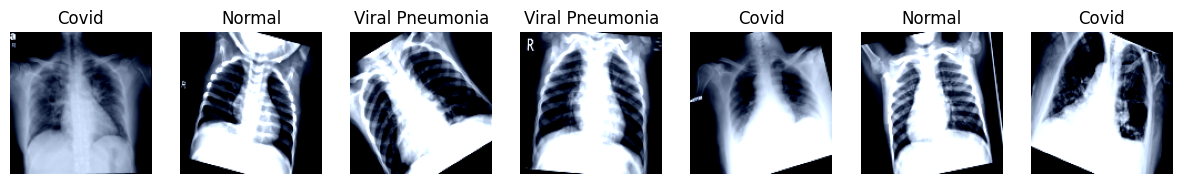

In [61]:
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

class_names = train_loader.dataset.dataset.classes
visualizeSamples(train_loader, class_names)

In [62]:
# Check data shape


# for batch_images, batch_class in train_loader:
#     print(batch_class)
#     print(batch_images.shape, batch_class.shape)

### CNN implementation

In [63]:
class CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(1024, 2048, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5) # dropout to enhance result
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv3(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv4(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv5(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv6(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv7(x))
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)
        x = self.dropout(x) # dropout implementation
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Train my model

In [64]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, device='cpu'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # L2-regularization

    best_val_acc = 0.0
    best_epoch = 0
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        start_time = time.time()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        epoch_train_losses.append(running_loss / len(train_loader))
        epoch_train_accuracies.append(train_acc)

        val_acc, val_loss = evaluate_model(model, val_loader, device)
        epoch_val_losses.append(val_loss)
        epoch_val_accuracies.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model.pth')  # Save the best model

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Val Loss: {val_loss:.4f}, "
              f"Time: {time.time() - start_time:.2f}s")

    plot_metrics(epoch_train_losses, epoch_val_losses, epoch_train_accuracies, epoch_val_accuracies)

    return model

In [65]:
def evaluate_model(model, val_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_acc = 100 * correct / total
    val_loss = running_loss / len(val_loader)

    return val_acc, val_loss

In [66]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Train and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Train and Validation Accuracy')

    plt.tight_layout()
    plt.show()

In [67]:
def load_best_model(model, device='cpu'):
    model.load_state_dict(torch.load('best_model.pth', weights_only=True))
    model = model.to(device)
    
    return model

In [68]:
def test_model(model, test_loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    all_preds = []
    all_labels = []
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.argmax(dim=1)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_loss = running_loss / len(test_loader)

    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

Epoch [1/10], Loss: 1.1431, Train Acc: 38.31%, Val Acc: 48.00%, Val Loss: 1.0182, Time: 25.40s
Epoch [2/10], Loss: 1.0885, Train Acc: 35.82%, Val Acc: 46.00%, Val Loss: 1.0783, Time: 21.81s
Epoch [3/10], Loss: 1.0892, Train Acc: 43.78%, Val Acc: 38.00%, Val Loss: 1.0960, Time: 22.07s
Epoch [4/10], Loss: 1.0727, Train Acc: 43.28%, Val Acc: 48.00%, Val Loss: 0.9069, Time: 23.38s
Epoch [5/10], Loss: 1.0332, Train Acc: 50.75%, Val Acc: 44.00%, Val Loss: 1.2000, Time: 21.42s
Epoch [6/10], Loss: 0.9740, Train Acc: 51.24%, Val Acc: 54.00%, Val Loss: 1.0502, Time: 22.66s
Epoch [7/10], Loss: 0.9539, Train Acc: 50.75%, Val Acc: 46.00%, Val Loss: 1.0754, Time: 22.82s
Epoch [8/10], Loss: 0.8345, Train Acc: 59.20%, Val Acc: 48.00%, Val Loss: 0.7487, Time: 22.25s
Epoch [9/10], Loss: 0.7820, Train Acc: 58.71%, Val Acc: 56.00%, Val Loss: 1.2967, Time: 22.95s
Epoch [10/10], Loss: 0.7038, Train Acc: 64.68%, Val Acc: 56.00%, Val Loss: 1.8696, Time: 22.51s


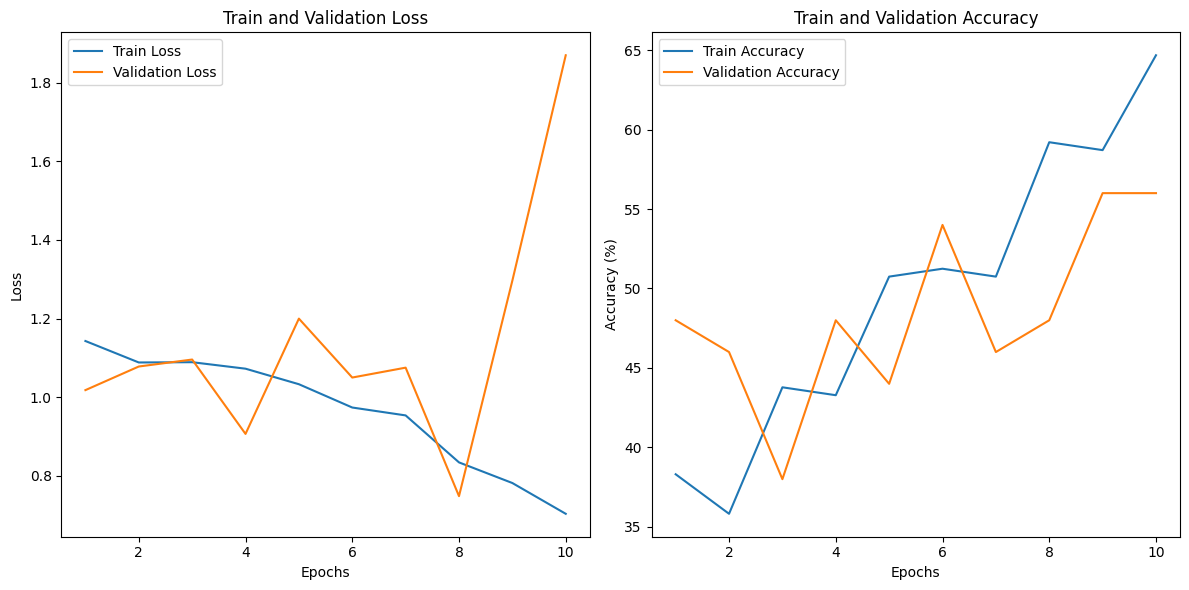

In [69]:
my_cnn = CNN(num_classes=3)
trained_model = train_model(my_cnn, train_loader, val_loader, num_epochs=10, learning_rate=0.001, weight_decay=1e-5, device='cpu')

### Print metrics of my implementation of CNN

In [70]:
best_model = load_best_model(my_cnn, device='cpu')
test_model(best_model, test_loader, device='cpu')

Test Loss: 0.8915
Test Accuracy: 54.55%
Precision: 0.4945
Recall: 0.5455
F1 Score: 0.4688


C:\Users\pzns1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Import pretrained models (ResNet & EfficientNet) and train them

In [100]:
import timm
from transformers import ResNetForImageClassification

In [90]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

EfficientNet

In [101]:
efficientnet = timm.create_model('tf_efficientnet_b0', pretrained=True)

num_features = efficientnet.classifier.in_features  # Получаем количество входных признаков
efficientnet.classifier = nn.Linear(num_features, 3)  # Заменяем на один выходной нейрон

In [89]:
efficientnet_train_loader, efficientnet_val_loader, efficientnet_test_loader = getDataLoaders(main_path, batch_size=32)

In [106]:
def train_efficientnet_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for inputs, one_hot_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)
        
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for inputs, one_hot_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
                labels = torch.argmax(one_hot_labels, dim=1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_efficientnet.pth')  # Сохраняем лучшую модель
        else:
            counter += 1
            if counter >= patience:
                print("Ранняя остановка сработала")
                break

In [98]:
efficientnet_criterion = nn.CrossEntropyLoss()

In [111]:
train_efficientnet_model(efficientnet, efficientnet_train_loader, efficientnet_val_loader, efficientnet_criterion, optimizer, num_epochs=10)

Epoch 1/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.81s/it]


Epoch 1/10
Train Loss: 1.0937, Train Acc: 0.3224
Val Loss: 1.0886, Val Acc: 0.3420


Epoch 2/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.83s/it]


Epoch 2/10
Train Loss: 1.0938, Train Acc: 0.3313
Val Loss: 1.1035, Val Acc: 0.2795


Epoch 3/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.79s/it]


Epoch 3/10
Train Loss: 1.1025, Train Acc: 0.2976
Val Loss: 1.1234, Val Acc: 0.3108


Epoch 4/10 (Val): 100%|██████████████████████████| 2/2 [00:03<00:00,  1.75s/it]

Epoch 4/10
Train Loss: 1.0987, Train Acc: 0.3403
Val Loss: 1.1223, Val Acc: 0.2795
Ранняя остановка сработала


In [113]:
def test_efficientnet_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.load_state_dict(torch.load('best_efficientnet.pth'))
    model.eval()

    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for inputs, one_hot_labels in tqdm(test_loader, desc="Testing"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_acc += accuracy(outputs, labels)
        
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

In [114]:
test_efficientnet_model(efficientnet, efficientnet_test_loader, efficientnet_criterion)

C:\Users\pzns1\AppData\Local\Temp\ipykernel_12428\672666349.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_efficientnet.pth'))
Te

Test Loss: 1.1206, Test Acc: 0.1562


ResNet

In [119]:
resnet = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

resnet_num_features = resnet.classifier[1].in_features 
resnet.classifier = nn.Linear(num_features, 3)

AttributeError: 'Sequential' object has no attribute 'in_features'

In [ ]:
resnet_criterion = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
resnet_train_loader, resnet_val_loader, efficientnet_test_loader = getDataLoaders(main_path, batch_size=32)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cpu")
    model = model.to(device)

    best_val_loss = float('inf')
    patience = 3
    counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for inputs, one_hot_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)"):
            inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
            labels = torch.argmax(one_hot_labels, dim=1)
            outputs = model(inputs).logits  # ResNet возвращает словарь, используем .logits
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_acc += accuracy(outputs, labels)
        
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for inputs, one_hot_labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Val)"):
                inputs, one_hot_labels = inputs.to(device), one_hot_labels.to(device)
                labels = torch.argmax(one_hot_labels, dim=1)
                outputs = model(inputs).logits  # ResNet возвращает словарь, используем .logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc += accuracy(outputs, labels)
        
        train_loss /= len(train_loader)
        train_acc /= len(train_loader)
        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_resnet.pth')
        else:
            counter += 1
            if counter >= patience:
                print("Ранняя остановка сработала")
                break

In [ ]:
train_resnet_model(resnet, resnet_train_loader, resnet_val_loader, resnet_criterion, resnet_optimizer, num_epochs=10)